In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image


dataset=pd.read_csv('/Users/Manish/Desktop/Datasets/quora_train.csv.zip')

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
dataset.head()
#print(dataset.shape)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
dataset['question1'][0]

'What is the step by step guide to invest in share market in india?'

In [4]:
dataset.values

array([[0, 1, 2,
        'What is the step by step guide to invest in share market in india?',
        'What is the step by step guide to invest in share market?', 0],
       [1, 3, 4, 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
        'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
        0],
       [2, 5, 6,
        'How can I increase the speed of my internet connection while using a VPN?',
        'How can Internet speed be increased by hacking through DNS?', 0],
       ...,
       [404287, 537928, 537929, 'What is one coin?', "What's this coin?",
        0],
       [404288, 537930, 537931,
        'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?',
        'I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?',
        0],
       [404289, 537932, 537933, 'What is like to have sex with cousin?',
        'Wh

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


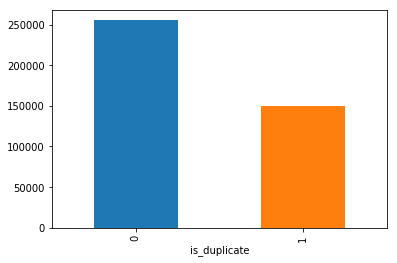

In [6]:
dataset.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
print('Total number of question pairs for training: {}'.format(len(dataset)))


Total number of question pairs for training: 404290


In [8]:
print("Total number of duplicate pairs:{}%".format(round(dataset['is_duplicate'].mean(),2)*100))


Total number of duplicate pairs:37.0%


In [9]:
qid=pd.Series(dataset['qid1'].tolist() + dataset['qid2'].tolist())
print(len(qid))
qid.shape

808580


(808580,)

In [10]:
print(len(np.unique(qid)))
print(len(dataset))

537933
404290


In [11]:
print("Number of questions that appear more than once:{}" .format(np.sum(qid.value_counts()>1)))
x=max(qid.value_counts())
x


Number of questions that appear more than once:111780


157

In [12]:
print("percentage of unique question that appear more than once:{}" .format(round(np.sum(qid.value_counts()>1)/len(np.unique(qid)),2)*100))

percentage of unique question that appear more than once:21.0


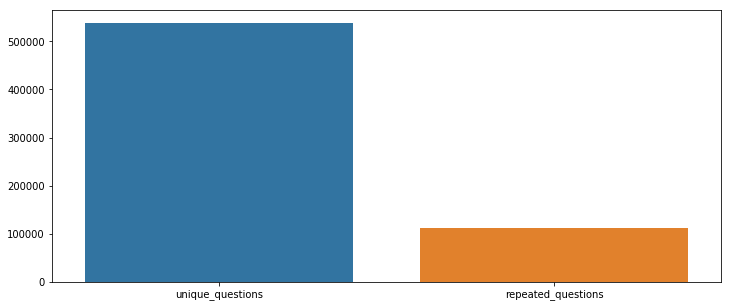

In [13]:
unique_questions=len(np.unique(qid))
repeated_questions=np.sum(qid.value_counts()>1)

x=["unique_questions", "repeated_questions"]
y=[unique_questions,repeated_questions]

plt.figure(figsize=(12,5))
sns.barplot(x,y)
plt.show()

In [14]:
duplicate_pairs= dataset[["qid1","qid2","is_duplicate"]].groupby(['qid1','qid2','is_duplicate']).count().reset_index()
duplicate_pairs

,qid1,qid2,is_duplicate
0,1,2,0
1,3,4,0
2,3,282170,0
3,3,380197,0
4,3,488853,0
5,4,32881,0
6,5,6,0
7,7,8,0
8,9,10,0
9,9,109465,0


In [15]:
#duplicate_pairs.shape[0]-dataset.shape[0] to check duplicate pairs

Text(0,0.5,'number of questions')

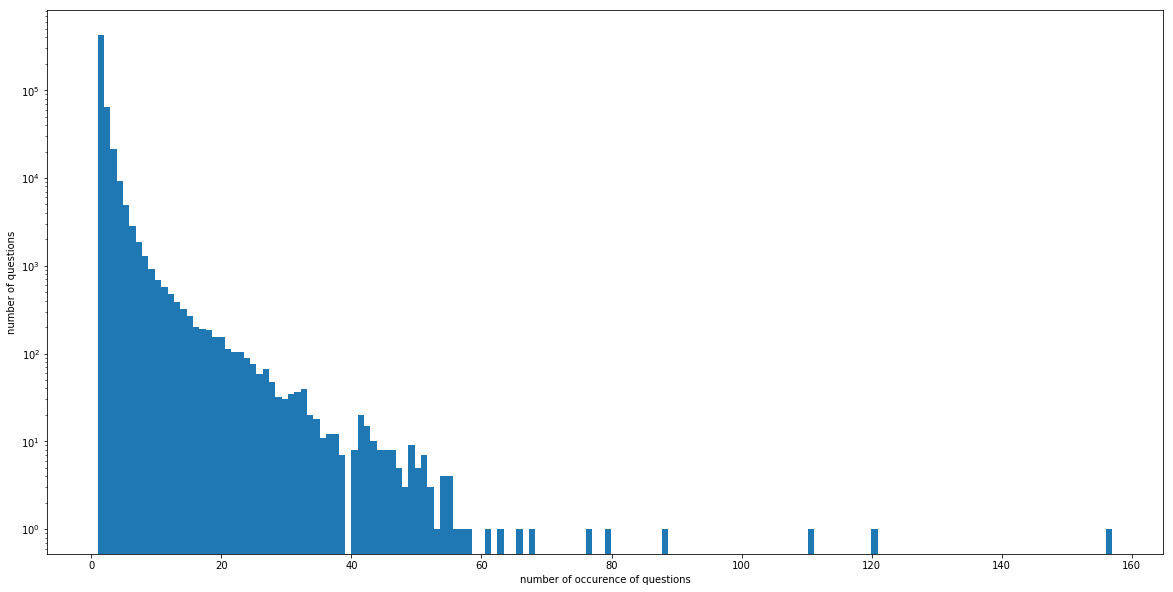

In [16]:
x=qid.value_counts()
plt.figure(figsize=(20,10))
plt.hist(x,bins=160)
plt.yscale('log', nonposy='clip')
plt.xlabel("number of occurence of questions")
plt.ylabel("number of questions")

In [17]:
null_check=dataset[dataset.isnull().any(1)]
null_check



,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [18]:
dataset= dataset.fillna(' ')
nan_rows=dataset[dataset.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [19]:
dataset["freq_q1"]= dataset.groupby("qid1")['id'].transform('count')
dataset["freq_q2"]= dataset.groupby("qid2")['id'].transform('count')
dataset["q1len"]=dataset["question1"].str.len()
dataset["q2len"]=dataset["question2"].str.len()

In [20]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_q1,freq_q2,q1len,q2len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39


In [21]:
dataset['q1_n_words'] = dataset['question1'].apply(lambda row: len(row.split(" ")))
dataset['q2_n_words'] = dataset['question2'].apply(lambda row: len(row.split(" ")))

In [22]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
dataset['word_Common'] = dataset.apply(normalized_word_Common, axis=1)

In [23]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
dataset['total_words'] = dataset.apply(normalized_word_Common, axis=1)

In [24]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return  1.0 *len(w1 & w2)/(len(w1) + len(w2))
dataset['word_share'] = dataset.apply(normalized_word_Common, axis=1)

In [25]:
dataset["freq_q1+q2"]=dataset.apply(lambda row: row['freq_q1']+row['freq_q2'],axis=1)
#dataset["freq_q1+q2"]=dataset['freq_q1']+dataset['freq_q2']

In [26]:
 dataset['freq_q1-q2'] = abs(dataset['freq_q1']-dataset['freq_q2'])

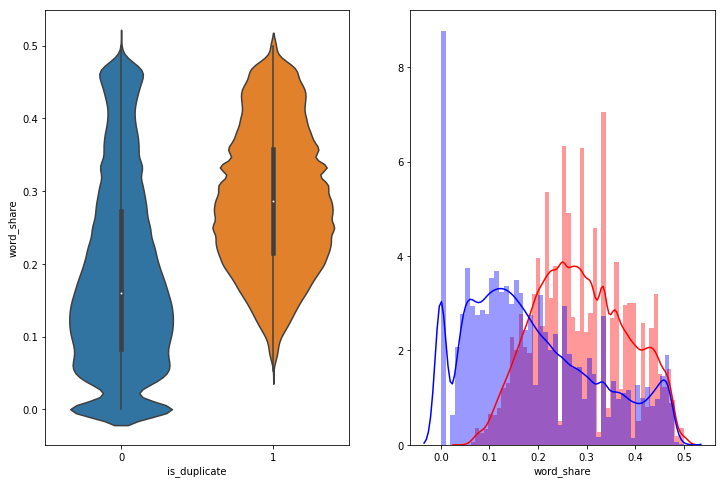

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = dataset[0:])

plt.subplot(1,2,2)
sns.distplot(dataset[dataset['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(dataset[dataset['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

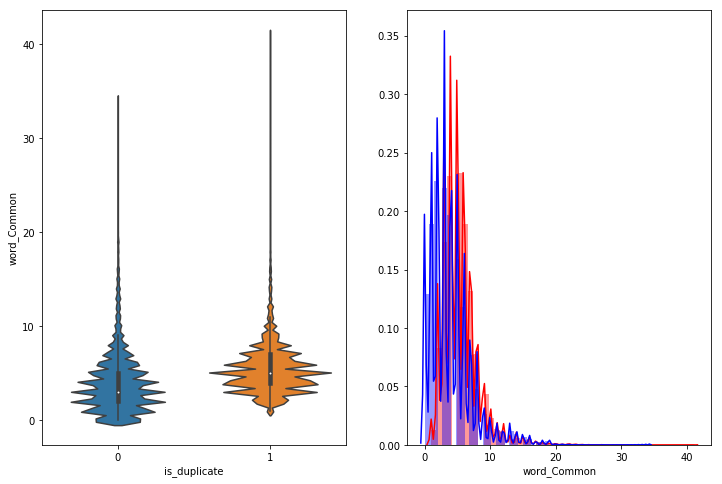

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=dataset[0:])
plt.subplot(1,2,2)
sns.distplot(dataset[dataset['is_duplicate']==1.0]['word_Common'][0:],label='1',color='red')
sns.distplot(dataset[dataset['is_duplicate']==0.0]['word_Common'][0:],label='0',color='blue')
plt.show


In [29]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [30]:
def get_token_features(q1,q2):
    token_features=[0.0]*100
    
    q1_token=q1.split()
    q2_token=q2.split()
    
    if len(q1_token)==0 or len(q2_token)==0:
        return token_features
    
    non_stop_words_q1= set([word for word in q1_token if word not in STOP_WORDS])
    non_stop_words_q2= set([word for word in q2_token if word not in STOP_WORDS])
    
    stop_words_in_q1= set([word for word in q1_token if word in STOP_WORDS])
    stop_words_in_q2= set([word for word in q2_token if word in STOP_WORDS])
    
    common_word_count=len(non_stop_words_q1.intersection(non_stop_words_q2))
    
    common_stop_count=len(stop_words_in_q1.intersection(stop_words_in_q2))
    
    common_token_count=len(set(q1_token).intersection(set(q2_token)))
    
    
    token_features[0] = common_word_count / (min(len(non_stop_words_q1), len(non_stop_words_q2)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(non_stop_words_q1), len(non_stop_words_q2)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(stop_words_in_q1), len(stop_words_in_q2)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(stop_words_in_q1), len(stop_words_in_q2)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_token), len(q2_token)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_token), len(q2_token)) + SAFE_DIV)
    
    token_features[6]=int(q1_token[-1]==q2_token[-1])
    
    token_features[7]=int(q1_token[0]==q2_token[0])
    
    token_features[8] = abs(len(q1_token) - len(q2_token))
    token_features[9]=(len(q1_token)+len(q2_token))/2
    
    
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

    
def extract_features(df):
    dataset["question1"]=dataset["question1"].fillna("").apply(preprocess)
    dataset["question2"]=dataset["question2"].fillna("").apply(preprocess)
    
    print("token_features")
    
    token_features= dataset.apply(lambda x: get_token_features(x["question1"], x["question2"]),axis=1)
    
    dataset["cwc_min"]= list(map(lambda x:x[0],token_features))
    dataset["cwc_max"]=list(map(lambda x:x[1],token_features))
    dataset["csc_min"]=list(map(lambda x:x[2],token_features))
    dataset["csc_max"]=list(map(lambda x:x[3],token_features))
    dataset["ctc_min"]=list(map(lambda x:x[4],token_features))
    dataset["ctc_max"]=list(map(lambda x:x[5],token_features))
    dataset["last_word_eq"]=list(map(lambda x: x[6], token_features))
    dataset["first_word_eq"]=list(map(lambda x: x[7], token_features))
    dataset["abs_len_diff"]=list(map(lambda x: x[8], token_features))
    dataset["mean_len"]=list(map(lambda x: x[9], token_features))
    
    
    
    print("Fuzzy_words")
    
    
    dataset["token_set_ratio"]=dataset.apply(lambda x:fuzz.token_set_ratio(x["question1"],x["question2"]),axis=1)
    dataset["token_sort_ratio"]=dataset.apply(lambda x:fuzz.token_sort_ratio(x["question1"],x["question2"]),axis=1)
    dataset["fuzz_ratio"]=dataset.apply(lambda x:fuzz.QRatio(x["question1"],x["question2"]),axis=1)
    dataset["fuzz_partial_ratio"]=dataset.apply(lambda x:fuzz.partial_ratio(x["question1"],x["question2"]),axis=1)
    dataset["longest_substr_ratio"]=dataset.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return dataset

In [31]:
if os.path.isfile('nlp_features_train2.csv'):
    df = pd.read_csv("nlp_features_train2.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv('/Users/Manish/Desktop/Datasets/quora_train.csv.zip')
    df = extract_features(df)
    df.to_csv("nlp_features_train2.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [32]:
df_is_duplicate=df[df["is_duplicate"]==1]
df_not_duplicate=df[df["is_duplicate"]==0]

p=np.dstack([df_is_duplicate["question1"],df_is_duplicate["question2"]]).flatten()
q=np.dstack([df_not_duplicate["question1"],df_not_duplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(q))

np.savetxt("train_p.txt",p,delimiter=' ',fmt='%s',encoding='utf-8')
np.savetxt("train_q.txt",q,delimiter=' ',fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [33]:
from os import path
from wordcloud import WordCloud, STOPWORDS

d=path.dirname('.')

textp_w=open(path.join(d,'train_p.txt'),encoding='utf-8').read()
textq_w=open(path.join(d,'train_q.txt'),encoding='utf-8').read()

print(len(textp_w))

stop_words=set(STOPWORDS)

stop_words.add("said")
stop_words.add("br")
stop_words.add(" ")
stop_words.remove("not")

stop_words.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stop_words.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textq_w))

16110737
Total number of words in duplicate pair questions : 16110737
Total number of words in non duplicate pair questions : 33200981


word cloud for duplicate question pair


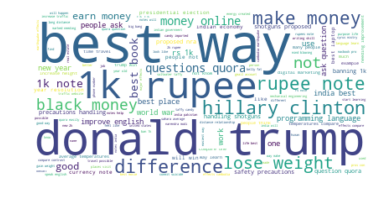

In [34]:
wc=WordCloud(background_color='white',max_words=len(textp_w),stopwords=stop_words)
wc.generate(textp_w)
print("word cloud for duplicate question pair")
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

word cloud for non duplicate pair


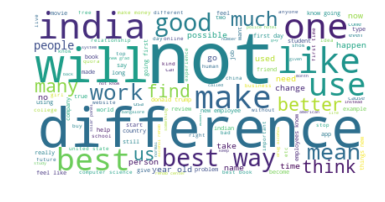

In [35]:
wc=WordCloud(background_color='white',max_words=len(textq_w),stopwords=stop_words)
wc.generate(textq_w)
print("word cloud for non duplicate pair")
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

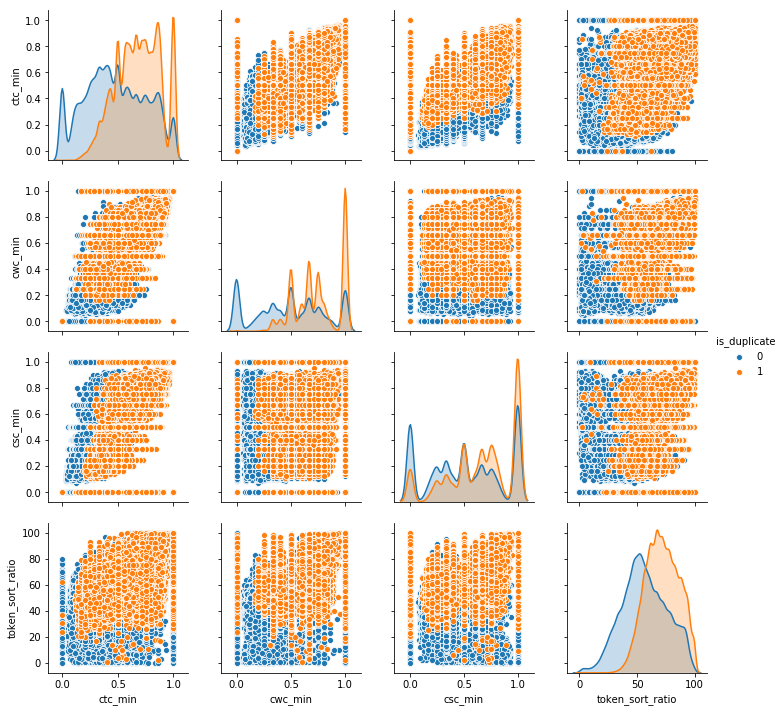

In [36]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

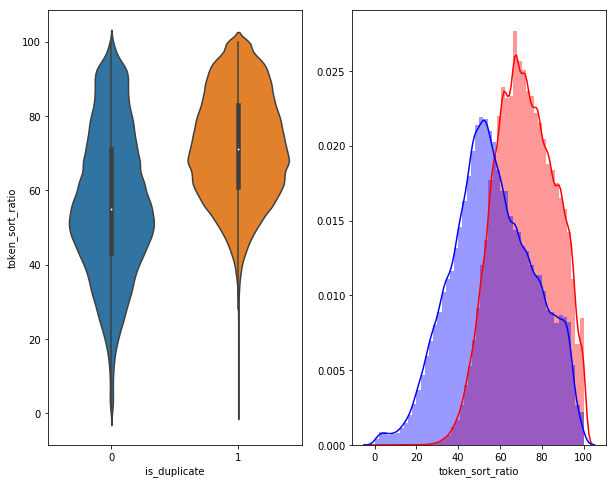

In [37]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['token_sort_ratio'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0.0]['token_sort_ratio'][0:],label='0',color='blue')
plt.show()

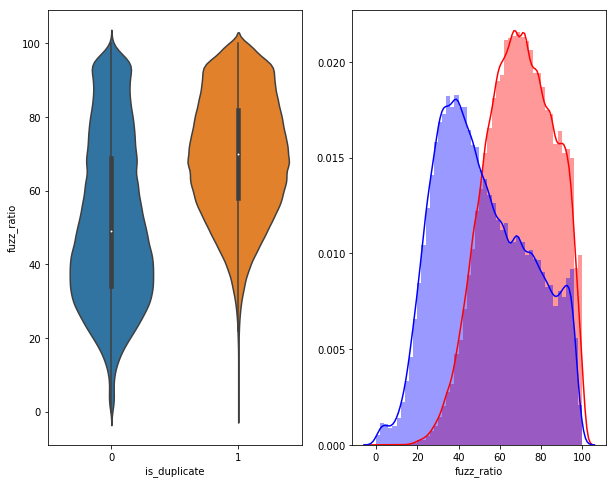

In [38]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='fuzz_ratio',data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_ratio'][0:],color='red',label='1')
sns.distplot(df[df['is_duplicate']==0.0]['fuzz_ratio'][0:],color='blue',label='0')
plt.show()

In [39]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled=df[0:5000]
x=MinMaxScaler().fit_transform(df_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y =df_subsampled['is_duplicate'].values

In [40]:
from sklearn.manifold import TSNE
tsne2d=TSNE(n_components=2,init='random',random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.084s...
[t-SNE] Computed neighbors for 5000 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.319s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 9.969s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 7.035s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 6.771s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 7.037s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.0039700

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



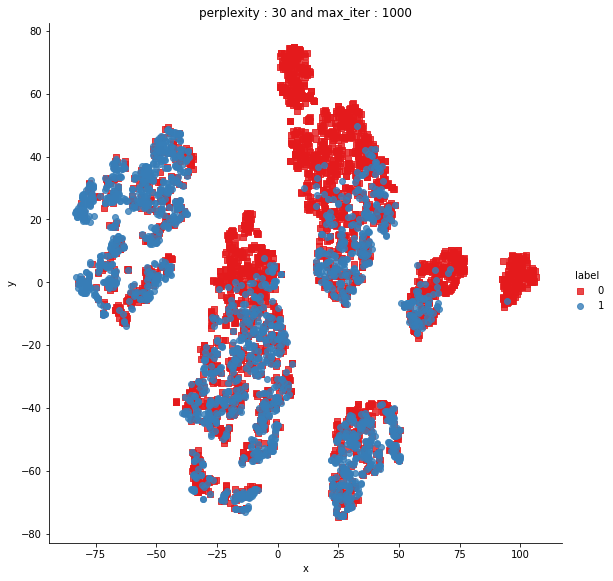

In [41]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

In [43]:
df=pd.read_csv('/Users/Manish/Desktop/Datasets/quora_train.csv.zip')
df['question1']=df['question1'].apply(lambda x: str(x))
df['question2']=df['question2'].apply(lambda x: str(x))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import en_core_web_sm

questions = list(df['question1']) + list(df['question2'])

tfidf=TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)


word2tfidf= dict(zip(tfidf.get_feature_names(), tfidf.idf_))


nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 

    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)





100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:10:36<00:00, 95.43it/s]


In [46]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [3:20:02<00:00, 33.68it/s]


In [48]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [49]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [50]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [51]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')